## **LIBRARY IMPORTS**

In [1]:
# Import Libraries
import cudf
import os
import joblib
import pywt
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb  # For reading MIT-BIH data
import keras_tuner as kt
import seaborn as sns
import tensorflow as tf
import neurokit2 as nk

# Scikit-learn and Imbalanced-learn imports
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import entropy
from collections import Counter
from scipy.signal import find_peaks, resample, butter, filtfilt, iirnotch, spectrogram
from sklearn.utils import class_weight

# Model imports
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Add, GlobalAveragePooling1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from cuml.ensemble import RandomForestClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight

# Additional setups
# Checking cUML
print(cudf.Series([1, 2, 3]))

# Setting TensorFlow flags
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Checking GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"TensorFlow has detected {len(gpu_devices)} GPU(s):")
    for device in gpu_devices:
        print(f"- {device}")
else:
    print("TensorFlow did not detect any GPUs. Training will run on the CPU.")


2025-08-22 07:53:47.291261: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-22 07:53:47.875237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755824028.039286    1126 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755824028.084250    1126 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755824028.482598    1126 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

0    1
1    2
2    3
dtype: int64
TensorFlow has detected 1 GPU(s):
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## **DATA PREPARATION**

### DATA PREPARATION FUNCTIONS
There are 3 types of functions:
1. Labels and windowed features of the RR intervals
2. Data preparation of MIT-BIH dataset as training and validation set
3. Data preparation of additional ECG data with a format of .bin as the final testing set

In [2]:
# 1. CONFIGURATIONS & ADDITIONAL FUNCTIONS
label_map = {
    'N': 0, '.': 0, 'L': 0, 'R': 0, 'e': 0, 'j': 0,  # Class 0: Normal Beats (N)
    'V': 1, 'E': 1,                                  # Class 1: Ventricular Ectopic (VEB)
    'S': 2, 'A': 2, 'a': 2, 'J': 2,                  # Class 2: Supraventricular Ectopic (SVEB)
    'F': 3                                           # Class 3: Fusion Beat (F)
}
DB_PATH_MIT = '../data/raw/MIT-BIH/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/'
FS_MIT = 360
FS_TARGET = 500
WINDOW_SIZE = int(FS_TARGET*0.8)  # 600ms window -> 0.6s * 500Hz
# Split MIT-BIH records into training and testing sets to prevent patient data leakage
RECORDS_TRAIN = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119',
                 '122', '124', '201', '203', '205', '207', '208', '209', '215', '220',
                 '223', '230'] # DS1
RECORDS_TEST = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202',
                '210', '212', '213', '214', '219', '221', '222', '228', '231', '232',
                '233', '234'] # DS2
custom_file_paths = {
    'Arrhythmia': '../data/raw/Arrhythmia/ECG_WAVE.bin',
    'Normal': '../data/raw/Normal/ecg_normal.bin' 
}
custom_file_labels = {'Arrhythmia': 2, 'Normal': 0} # SVEB and Normal

# Wavelet Feature Configuration
WAVELET_TYPE = 'db4'
WAVELET_LEVEL = 4

# Define the output directory
output_dir_prepare_data = '../data/processed'
os.makedirs(output_dir_prepare_data, exist_ok=True) # This creates the directory if it doesn't exist

# Filtering ECG data on a certain frequencies
def preprocess_signal(signal, fs=500):
    """
    Applies a multi-stage denoising pipeline to a raw ECG signal.
    This pipeline is designed to remove baseline wander, powerline interference,
    and high-frequency noise to maximize signal-to-noise ratio.
    """
    # Ensure signal is a numpy array
    signal = np.array(signal)
    
    # Step 1: Remove baseline wander with a high-pass Butterworth filter.
    nyq = 0.5 * fs
    low_cutoff = 0.6
    b, a = butter(2, low_cutoff / nyq, btype='high')
    signal_bw_removed = filtfilt(b, a, signal)

    # Step 2: Remove powerline interference with a notch filter (50Hz for Indonesia).
    powerline_freq = 50
    b, a = iirnotch(powerline_freq / nyq, Q=30)
    signal_pl_removed = filtfilt(b, a, signal_bw_removed)

    # Step 3: Attenuate high-frequency noise with a low-pass Butterworth filter.
    high_cutoff = 100
    b, a = butter(4, high_cutoff / nyq, btype='low')
    cleaned_signal = filtfilt(b, a, signal_pl_removed)
    
    return cleaned_signal

# Extract features of wavelet
def extract_wavelet_features(window, wavelet='db4', level=4):
    """
    Extracts statistical and entropy-based features from the wavelet coefficients of an ECG window.
    
    Args:
        window (np.ndarray): A 1D numpy array representing a single ECG beat window.
        wavelet (str): The type of wavelet to use.
        level (int): The level of wavelet decomposition.
        
    Returns:
        np.ndarray: A 1D numpy array containing the extracted features.
    """
    # Decompose the signal
    coeffs = pywt.wavedec(window, wavelet, level=level)
    
    features = []
    for c in coeffs:
        # Basic statistical features
        features.append(np.mean(c))
        features.append(np.std(c))
        features.append(np.var(c))
        
        # Energy of the coefficients
        features.append(np.sum(np.square(c)))
        
        # Shannon Entropy of the coefficients
        # We use the squared coeffs to represent energy distribution for entropy calculation
        # Adding a small epsilon to avoid log(0)
        features.append(entropy(np.square(c) + 1e-9))
        
    return np.array(features)

# Wavelet Packet Transformation
def extract_wpt_features(window, wavelet='db4', level=4):
    """
    Extracts statistical features from the Wavelet Packet Transform (WPT) 
    coefficients of an ECG window for a more detailed analysis.
    """
    # Create the wavelet packet object
    wp = pywt.WaveletPacket(data=window, wavelet=wavelet, mode='symmetric', maxlevel=level)
    
    # Get the coefficient nodes at the specified level
    nodes = wp.get_level(level, order='natural')
    # Extract the data (coefficients) from each node
    coeffs = [node.data for node in nodes]
    
    features = []
    for c in coeffs:
        # Basic statistical features
        features.append(np.mean(c))
        features.append(np.std(c))
        features.append(np.var(c))
        
        # Energy of the coefficients
        features.append(np.sum(np.square(c)))
        
        # Shannon Entropy of the coefficients
        features.append(entropy(np.square(c) + 1e-9))
        
    return np.array(features)

In [3]:
# 2. DATA LOADING UTILITY OF MIT-BIH DATA
# This function efficiently loads the specified records and their annotations.
def load_mitbih_records(db_path, record_names):
    """
    Loads raw ECG signals and annotations for specified records from both leads.

    Args:
        db_path (str): The path to the database directory.
        record_names (list): A list of record names as strings.

    Returns:
        A tuple containing three lists: (signals_leadA, signals_leadB, annotations).
        - signals_leadA: A list of raw ECG signal arrays for channel 0.
        - signals_leadB: A list of raw ECG signal arrays for channel 1.
        - annotations: A list of wfdb Annotation objects.
    """
    signals_leadA = []
    signals_leadB = []
    all_annotations = []
    print(f"Loading records: {', '.join(record_names)}...")
    for rec_name in record_names:
        record_path = f'{db_path}/{rec_name}'
        try:
            # Read both channels (0 and 1)
            record = wfdb.rdrecord(record_path, channels=[0, 1])
            signals_leadA.append(record.p_signal[:, 0].flatten())
            signals_leadB.append(record.p_signal[:, 1].flatten())
            
            # Annotations are the same for both leads
            annotation = wfdb.rdann(record_path, 'atr')
            all_annotations.append(annotation)
        except Exception as e:
            print(f"Error processing record {rec_name}: {e}")
    print("Loading complete.")
    return signals_leadA, signals_leadB, all_annotations

# DWT
# def prepare_dwt_and_raw_data(signals_A, signals_B, annotations, window_size, fs=360, target_fs=500):
#     """
#     Processes dual-lead MIT-BIH data once to generate both DWT features and raw windows.
#     """
#     all_dwt_features, all_raw_windows, all_labels = [], [], []
#     samples_before = window_size // 3
#     samples_after = window_size - samples_before

#     for i, (raw_signal_A, raw_signal_B) in enumerate(zip(signals_A, signals_B)):
#         ann = annotations[i]
#         try:
#             resampled_A = resample(raw_signal_A, int(len(raw_signal_A) * (target_fs / fs)))
#             cleaned_A = preprocess_signal(resampled_A, fs=target_fs)
#             resampled_B = resample(raw_signal_B, int(len(raw_signal_B) * (target_fs / fs)))
#             cleaned_B = preprocess_signal(resampled_B, fs=target_fs)
#             r_peaks_resampled = np.round(ann.sample * (target_fs / fs)).astype(int)

#             for j, r_peak_loc in enumerate(r_peaks_resampled):
#                 symbol = ann.symbol[j]
#                 if symbol in label_map:
#                     start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
#                     if start >= 0 and end < len(cleaned_A):
#                         window_A, window_B = cleaned_A[start:end], cleaned_B[start:end]
                        
#                         # DWT Features: Concatenate from both leads
#                         dwt_A = extract_wavelet_features(window_A)
#                         dwt_B = extract_wavelet_features(window_B)
#                         all_dwt_features.append(np.concatenate((dwt_A, dwt_B)))
                        
#                         # Raw Windows: Stack into a 2-channel array
#                         all_raw_windows.append(np.stack((window_A, window_B), axis=-1))
#                         all_labels.append(label_map[symbol])
#         except Exception as e:
#             print(f"Could not process record {ann.record_name}: {e}")

#     return np.array(all_dwt_features), np.array(all_raw_windows), np.array(all_labels)

# =============================================================================
# SECTION 2: MODIFIED UNIFIED DATA PREPARATION FUNCTIONS (WITH WPT)
# =============================================================================
# WPT
def prepare_wpt_and_raw_data(signals_A, signals_B, annotations, window_size, fs=360, target_fs=500):
    """
    Processes dual-lead MIT-BIH data once to generate both WPT features and raw windows.
    """
    all_wpt_features, all_raw_windows, all_labels = [], [], []
    samples_before = window_size // 3
    samples_after = window_size - samples_before

    for i, (raw_signal_A, raw_signal_B) in enumerate(zip(signals_A, signals_B)):
        ann = annotations[i]
        try:
            resampled_A = resample(raw_signal_A, int(len(raw_signal_A) * (target_fs / fs)))
            cleaned_A = preprocess_signal(resampled_A, fs=target_fs)
            resampled_B = resample(raw_signal_B, int(len(raw_signal_B) * (target_fs / fs)))
            cleaned_B = preprocess_signal(resampled_B, fs=target_fs)
            r_peaks_resampled = np.round(ann.sample * (target_fs / fs)).astype(int)

            for j, r_peak_loc in enumerate(r_peaks_resampled):
                symbol = ann.symbol[j]
                if symbol in label_map:
                    start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
                    if start >= 0 and end < len(cleaned_A):
                        window_A, window_B = cleaned_A[start:end], cleaned_B[start:end]
                        
                        # WPT Features: Concatenate from both leads
                        wpt_A = extract_wpt_features(window_A)
                        wpt_B = extract_wpt_features(window_B)
                        all_wpt_features.append(np.concatenate((wpt_A, wpt_B)))
                        
                        # Raw Windows: Stack into a 2-channel array
                        all_raw_windows.append(np.stack((window_A, window_B), axis=-1))
                        all_labels.append(label_map[symbol])
        except Exception as e:
            print(f"Could not process record {ann.record_name}: {e}")

    return np.array(all_wpt_features), np.array(all_raw_windows), np.array(all_labels)

In [4]:
# 3. DATA LOADING FOR .bin FILES
# A function to load ECG data
def load_ecg_from_bin(file_path, dtype=np.int16):
    """
    Loading raw ECG signals from binary files.

    Args:
        file_path (str): Path to the .bin file.
        dtype (numpy.dtype): Data type of the signal in the .bin file.

    Return:
        numpy.ndarray: ECG signals as a numpy array.
    """
    try:
        signal = np.fromfile(file_path, dtype=dtype)
        print(f"Completed reading {len(signal)} samples from {file_path}")
        return signal
    except IOError as e:
        print(f"An error has occurred while reading: {e}")
        return None

# A function to detect R-peaks for labelling
def detect_r_peaks_robust(signal, fs):
    """Detects R-peaks using a robust algorithm from NeuroKit2."""
    try:
        _, rpeaks_dict = nk.ecg_peaks(signal, sampling_rate=fs)
        r_peaks = rpeaks_dict['ECG_R_Peaks']
        print(f"Detected {len(r_peaks)} R-peaks.")
        return r_peaks
    except Exception as e:
        print(f"Could not detect R-peaks: {e}")
        return np.array([])

# DWT
# def prepare_dwt_and_raw_data_from_bin(signal, r_peaks, window_size, label, wavelet='db4', level=4, target_fs=500):
#     """
#     Processes a single-lead .bin file to generate both DWT features and raw windows.
#     Duplicates features to match the dual-lead format.
#     """
#     all_dwt_features, all_raw_windows, all_labels = [], [], []
#     samples_before = window_size // 3
#     samples_after = window_size - samples_before
#     cleaned_signal = preprocess_signal(signal, fs=target_fs)

#     for r_peak_loc in r_peaks:
#         start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
#         if start >= 0 and end < len(cleaned_signal):
#             window = cleaned_signal[start:end]
            
#             # DWT Features: Extract and duplicate
#             dwt_features = extract_wavelet_features(window, wavelet=wavelet, level=level)
#             all_dwt_features.append(np.concatenate((dwt_features, dwt_features)))
            
#             # Raw Windows: Stack duplicated window for 2 channels
#             all_raw_windows.append(np.stack((window, window), axis=-1))
#             all_labels.append(label)
            
#     return np.array(all_dwt_features), np.array(all_raw_windows), np.array(all_labels)

# WPT
def prepare_wpt_and_raw_data_from_bin(signal, r_peaks, window_size, label, wavelet='db4', level=4, target_fs=500):
    """
    Processes a single-lead .bin file to generate both WPT features and raw windows.
    Duplicates features to match the dual-lead format.
    """
    all_wpt_features, all_raw_windows, all_labels = [], [], []
    samples_before = window_size // 3
    samples_after = window_size - samples_before
    cleaned_signal = preprocess_signal(signal, fs=target_fs)

    for r_peak_loc in r_peaks:
        start, end = r_peak_loc - samples_before, r_peak_loc + samples_after
        if start >= 0 and end < len(cleaned_signal):
            window = cleaned_signal[start:end]
            
            # WPT Features: Extract and duplicate
            wpt_features = extract_wpt_features(window, wavelet=wavelet, level=level)
            all_wpt_features.append(np.concatenate((wpt_features, wpt_features)))
            
            # Raw Windows: Stack duplicated window for 2 channels
            all_raw_windows.append(np.stack((window, window), axis=-1))
            all_labels.append(label)
            
    return np.array(all_wpt_features), np.array(all_raw_windows), np.array(all_labels)

### DATA PREPARATION EXECUTION
1. Reading all ECG datasets
2. Divide all datasets into training dataset and testing dataset
3. Standard scaling and combining datasets
4. Splitting training dataset into training split and validation split then applying SMOTE algorithm into the training split
5. Preparing all the datasets for each machine learning model
The feature extraction of this data is transforming the data into wavelet data. Beforehand, the data was transformed into RR-intervals only data, but the data provided is limited to its RR-intervals and it didn't represent the heartbeat morphology of the data. Then, it was transformed into raw ECG data which is better than before, but the data was costly and thus needed further transformation. Lastly, it is transformed into wavelet data

In [5]:
if __name__ == '__main__':
    print("--- [Step 1] Processing Multi-Lead MIT-BIH Data ---")
    print("\nProcessing MIT-BIH Training set (DS1)...")
    train_signals_A, train_signals_B, train_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TRAIN)
    X_train_dwt, X_train_raw, y_train_mit = prepare_dwt_and_raw_data(train_signals_A, train_signals_B, train_anns, WINDOW_SIZE, fs=FS_MIT, target_fs=FS_TARGET)
    print(f"Combined MIT-BIH Training DWT feature matrix shape: {X_train_dwt.shape}")
    print(f"Combined MIT-BIH Training Raw window matrix shape: {X_train_raw.shape}")

    print("\nProcessing MIT-BIH Testing set (DS2)...")
    test_signals_A, test_signals_B, test_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TEST)
    X_test_dwt_mit, X_test_raw_mit, y_test_mitbih = prepare_dwt_and_raw_data(test_signals_A, test_signals_B, test_anns, WINDOW_SIZE, fs=FS_MIT, target_fs=FS_TARGET)
    print(f"Combined MIT-BIH Testing DWT feature matrix shape: {X_test_dwt_mit.shape}")
    print(f"Combined MIT-BIH Testing Raw window matrix shape: {X_test_raw_mit.shape}")

    # --- [Step 2] Process Single-Lead Custom Data ---
    print("\n--- [Step 2] Processing Single-Lead Custom Data ---")
    X_test_custom_pwt_list, X_test_custom_raw_list, y_test_custom_list = [], [], []
    for name, path in custom_file_paths.items():
        label = custom_file_labels[name]
        signal = load_ecg_from_bin(path)
        if signal is not None:
            r_peaks = detect_r_peaks_robust(signal, fs=FS_TARGET)
            dwt_single, raw_single, y_single = prepare_dwt_and_raw_data_from_bin(
                signal, r_peaks, WINDOW_SIZE, label, wavelet=WAVELET_TYPE, level=WAVELET_LEVEL, target_fs=FS_TARGET
            )
            X_test_custom_dwt_list.append(dwt_single)
            X_test_custom_raw_list.append(raw_single)
            y_test_custom_list.append(y_single)
            
    X_test_custom_dwt = np.vstack(X_test_custom_dwt_list)
    X_test_custom_raw = np.vstack(X_test_custom_raw_list)
    y_test_custom = np.concatenate(y_test_custom_list)
    print(f"Combined Custom Testing DWT feature matrix shape: {X_test_custom_pwt.shape}")
    print(f"Combined Custom Testing Raw window matrix shape: {X_test_custom_raw.shape}")

    # --- [Step 3] Finalize Datasets and Scale PWT data ---
    print("\n--- [Step 3] Scaling and Finalizing Data ---")
    X_train_dwt_base = X_train_dwt 
    y_train = y_train_mit
    
    scaler = StandardScaler()
    X_train_dwt_scaled = scaler.fit_transform(X_train_dwt_base)
    print("Scaler trained on PWT training data.")
    
    X_test_dwt_mit_scaled = scaler.transform(X_test_dwt_mit)
    X_test_dwt_custom_scaled = scaler.transform(X_test_custom_dwt)
    
    # Combine test sets
    X_test_dwt_final = np.concatenate((X_test_dwt_mit_scaled, X_test_dwt_custom_scaled), axis=0)
    X_test_raw_final = np.concatenate((X_test_raw_mit, X_test_custom_raw), axis=0)
    y_test_final = np.concatenate((y_test_mitbih, y_test_custom), axis=0)
    
    # --- [Step 4] Splitting & Hybrid Sampling for DWT data ---
    print("\n--- [Step 4] Finalizing Training Data (Split & Hybrid Sample) ---")
    X_train_dwt_fold, X_val_dwt_fold, y_train_fold, y_val_fold = train_test_split(
        X_train_dwt_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    # Also split the corresponding raw data for the CNN with the same indices
    X_train_raw_fold, X_val_raw_fold, _, _ = train_test_split(
        X_train_raw, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print("Applying HYBRID SAMPLING (SMOTEENN) to DWT training data...")
    print("Class distribution before sampling:", Counter(y_train_fold))
    sampler = ADASYN(random_state=42)
    X_train_dwt_resampled, y_train_dwt_resampled = sampler.fit_resample(X_train_dwt_fold, y_train_fold)
    print("Class distribution after sampling:", Counter(y_train_dwt_resampled))

    # --- [Step 5] Final Data Preparation for Models ---
    print("\n--- [Step 5] Preparing Final Datasets for Models ---")
    output_dim = len(np.unique(y_train))
    
    # Data for MLP
    X_train_mlp, y_train_mlp = X_train_dwt_resampled, to_categorical(y_train_dwt_resampled, num_classes=output_dim)
    X_val_mlp, y_val_mlp = X_val_dwt_fold, to_categorical(y_val_fold, num_classes=output_dim)
    X_test_mlp, y_test_mlp = X_test_dwt_final, to_categorical(y_test_final, num_classes=output_dim)

    # Data for 1D-CNN
    # **CORRECTION**: Use the raw window data, not the DWT features
    X_train_cnn, y_train_cnn = X_train_raw_fold, to_categorical(y_train_fold, num_classes=output_dim)
    X_val_cnn, y_val_cnn = X_val_raw_fold, to_categorical(y_val_fold, num_classes=output_dim)
    X_test_cnn, y_test_cnn = X_test_raw_final, to_categorical(y_test_final, num_classes=output_dim)

    # Data for RandomForest
    X_train_rf, y_train_rf = X_train_dwt_resampled, y_train_dwt_resampled
    X_val_rf, y_val_rf = X_val_dwt_fold, y_val_fold
    X_test_rf, y_test_rf = X_test_dwt_final, y_test_final

    print("\n" + "="*60)
    print("✅ DATA PREPARATION COMPLETE ✅")
    print(f"Shapes for MLP -> Train: {X_train_mlp.shape}, Val: {X_val_mlp.shape}, Test: {X_test_mlp.shape}")
    print(f"Shapes for 1D-CNN -> Train: {X_train_cnn.shape}, Val: {X_val_cnn.shape}, Test: {X_test_cnn.shape}")
    print(f"Shapes for RandomForest -> Train: {X_train_rf.shape}, Val: {X_val_rf.shape}, Test: {X_test_rf.shape}")
    print("="*60)

--- [Step 1] Processing Multi-Lead MIT-BIH Data ---

Processing MIT-BIH Training set (DS1)...
Loading records: 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230...
Loading complete.


NameError: name 'prepare_dwt_and_raw_data' is not defined

In [6]:
if __name__ == '__main__':
    print("--- [Step 1] Processing Multi-Lead MIT-BIH Data ---")
    print("\nProcessing MIT-BIH Training set (DS1)...")
    train_signals_A, train_signals_B, train_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TRAIN)
    X_train_wpt, X_train_raw, y_train_mit = prepare_wpt_and_raw_data(train_signals_A, train_signals_B, train_anns, WINDOW_SIZE, fs=FS_MIT, target_fs=FS_TARGET)
    print(f"Combined MIT-BIH Training WPT feature matrix shape: {X_train_wpt.shape}")
    print(f"Combined MIT-BIH Training Raw window matrix shape: {X_train_raw.shape}")

    print("\nProcessing MIT-BIH Testing set (DS2)...")
    test_signals_A, test_signals_B, test_anns = load_mitbih_records(DB_PATH_MIT, RECORDS_TEST)
    X_test_wpt_mit, X_test_raw_mit, y_test_mitbih = prepare_wpt_and_raw_data(test_signals_A, test_signals_B, test_anns, WINDOW_SIZE, fs=FS_MIT, target_fs=FS_TARGET)
    print(f"Combined MIT-BIH Testing WPT feature matrix shape: {X_test_wpt_mit.shape}")
    print(f"Combined MIT-BIH Testing Raw window matrix shape: {X_test_raw_mit.shape}")

    # --- [Step 2] Process Single-Lead Custom Data ---
    print("\n--- [Step 2] Processing Single-Lead Custom Data ---")
    X_test_custom_wpt_list, X_test_custom_raw_list, y_test_custom_list = [], [], []
    for name, path in custom_file_paths.items():
        label = custom_file_labels[name]
        signal = load_ecg_from_bin(path)
        if signal is not None:
            r_peaks = detect_r_peaks_robust(signal, fs=FS_TARGET)
            wpt_single, raw_single, y_single = prepare_wpt_and_raw_data_from_bin(
                signal, r_peaks, WINDOW_SIZE, label, wavelet=WAVELET_TYPE, level=WAVELET_LEVEL, target_fs=FS_TARGET
            )
            X_test_custom_wpt_list.append(wpt_single)
            X_test_custom_raw_list.append(raw_single)
            y_test_custom_list.append(y_single)
            
    X_test_custom_wpt = np.vstack(X_test_custom_wpt_list)
    X_test_custom_raw = np.vstack(X_test_custom_raw_list)
    y_test_custom = np.concatenate(y_test_custom_list)
    print(f"Combined Custom Testing WPT feature matrix shape: {X_test_custom_wpt.shape}")
    print(f"Combined Custom Testing Raw window matrix shape: {X_test_custom_raw.shape}")

    # --- [Step 3] Finalize Datasets and Scale WPT data ---
    print("\n--- [Step 3] Scaling and Finalizing Data ---")
    X_train_wpt_base = X_train_wpt
    y_train = y_train_mit
    
    scaler = StandardScaler()
    X_train_wpt_scaled = scaler.fit_transform(X_train_wpt_base)
    print("Scaler trained on WPT training data.")
    
    X_test_wpt_mit_scaled = scaler.transform(X_test_wpt_mit)
    X_test_wpt_custom_scaled = scaler.transform(X_test_custom_wpt)
    
    # Combine test sets
    X_test_wpt_final = np.concatenate((X_test_wpt_mit_scaled, X_test_wpt_custom_scaled), axis=0)
    X_test_raw_final = np.concatenate((X_test_raw_mit, X_test_custom_raw), axis=0)
    y_test_final = np.concatenate((y_test_mitbih, y_test_custom), axis=0)
    
    # --- [Step 4] Splitting & Hybrid Sampling for WPT data ---
    print("\n--- [Step 4] Finalizing Training Data (Split & Hybrid Sample) ---")
    X_train_wpt_fold, X_val_wpt_fold, y_train_fold, y_val_fold = train_test_split(
        X_train_wpt_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    # Also split the corresponding raw data for the CNN with the same indices
    X_train_raw_fold, X_val_raw_fold, _, _ = train_test_split(
        X_train_raw, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print("Applying sampling to WPT training data...")
    print("Class distribution before sampling:", Counter(y_train_fold))
    sampler = SMOTE(random_state=42)
    X_train_wpt_resampled, y_train_wpt_resampled = sampler.fit_resample(X_train_wpt_fold, y_train_fold)
    print("Class distribution after sampling:", Counter(y_train_wpt_resampled))

    # --- [Step 5] Final Data Preparation for Models ---
    print("\n--- [Step 5] Preparing Final Datasets for Models ---")
    output_dim = len(np.unique(y_train))
    
    # Data for MLP
    X_train_mlp, y_train_mlp = X_train_wpt_resampled, to_categorical(y_train_wpt_resampled, num_classes=output_dim)
    X_val_mlp, y_val_mlp = X_val_wpt_fold, to_categorical(y_val_fold, num_classes=output_dim)
    X_test_mlp, y_test_mlp = X_test_wpt_final, to_categorical(y_test_final, num_classes=output_dim)

    # Data for 1D-CNN
    # **CORRECTION**: Use the raw window data, not the WPT features
    X_train_cnn, y_train_cnn = X_train_raw_fold, to_categorical(y_train_fold, num_classes=output_dim)
    X_val_cnn, y_val_cnn = X_val_raw_fold, to_categorical(y_val_fold, num_classes=output_dim)
    X_test_cnn, y_test_cnn = X_test_raw_final, to_categorical(y_test_final, num_classes=output_dim)

    # Data for RandomForest
    X_train_rf, y_train_rf = X_train_wpt_resampled, y_train_wpt_resampled
    X_val_rf, y_val_rf = X_val_wpt_fold, y_val_fold
    X_test_rf, y_test_rf = X_test_wpt_final, y_test_final

    print("\n" + "="*60)
    print("✅ DATA PREPARATION COMPLETE ✅")
    print(f"Shapes for MLP -> Train: {X_train_mlp.shape}, Val: {X_val_mlp.shape}, Test: {X_test_mlp.shape}")
    print(f"Shapes for 1D-CNN -> Train: {X_train_cnn.shape}, Val: {X_val_cnn.shape}, Test: {X_test_cnn.shape}")
    print(f"Shapes for RandomForest -> Train: {X_train_rf.shape}, Val: {X_val_rf.shape}, Test: {X_test_rf.shape}")
    print("="*60)

--- [Step 1] Processing Multi-Lead MIT-BIH Data ---

Processing MIT-BIH Training set (DS1)...
Loading records: 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230...
Loading complete.
Combined MIT-BIH Training WPT feature matrix shape: (50992, 160)
Combined MIT-BIH Training Raw window matrix shape: (50992, 400, 2)

Processing MIT-BIH Testing set (DS2)...
Loading records: 100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234...
Loading complete.
Combined MIT-BIH Testing WPT feature matrix shape: (49683, 160)
Combined MIT-BIH Testing Raw window matrix shape: (49683, 400, 2)

--- [Step 2] Processing Single-Lead Custom Data ---
Completed reading 2380000 samples from ../data/raw/Arrhythmia/ECG_WAVE.bin
Detected 56 R-peaks.
Completed reading 2135000 samples from ../data/raw/Normal/ecg_normal.bin
Detected 11 R-peaks.
Combined Custom Testing WPT feature matrix shape: (67, 160)
Combin

## **MACHINE LEARNING MODEL TRAINING & SAVING**

### MACHINE LEARNING MODEL FUNCTIONS
There are 3 models that will be trained:
1. MLP Model (TA242501010)
2. 1D-CNN
3. BalancedRandomForest

There is also an additional function in order to do automatic hyperparameter tuning, but the function is only made for the MLP model.

In [7]:
# Function to build the MLP model for automatic hyperparameter tuning
def build_model(hp):
    """Function that builds a Keras model and defines the hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of units in the first hidden layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units_1, activation='relu', input_shape=(X_train.shape[1],)))

    # Tune the dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_1))

    # Tune the number of units in the second hidden layer
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units_2, activation='relu'))

    # Tune the dropout rate
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout_2))
    model.add(Dense(output_dim, activation='softmax'))

    # Tune the learning rate for the Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(name='auc_pr', curve='PR'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score')
        ]
    )
    return model

# Function to create the 1D-CNN model
def create_cnn_model(input_shape, output_dim):
    """Creates and compiles a Keras 1D-CNN model."""
    # Input shape for CNN must be 3D: (samples, steps, features)
    # Example: (10000, 187, 1)

    model = Sequential([
        Conv1D(filters=512, kernel_size=6, activation='relu', # Reduced filters
               input_shape=input_shape),
        Dropout(0.1),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=512, kernel_size=3, activation='relu'), # Reduced filters
        Dropout(0.2),
        MaxPooling1D(pool_size=2),

        Flatten(), # Now flattens a much smaller tensor

        Dense(512, activation='relu'), # Reduced dense units
        Dropout(0.4),

        Dense(output_dim, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

# Function to create the MLP model for cross-validation
def create_mlp_model(input_dim, output_dim):
    """Creates and compiles a Keras MLP model."""
    model = Sequential([
        # Hyperparameters tuning
        Dense(512, input_dim=input_dim, activation='relu'),
        Dropout(0.1),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(output_dim, activation='softmax') # Softmax for multi-class classification
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy', # Suitable for one-hot labels
        metrics=[
            #'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

def create_cnn_model_optimized(input_shape, output_dim, hp=None):
    """
    Creates and compiles an optimized 1D-CNN model.
    If 'hp' is provided, it builds a tunable model for KerasTuner.
    Otherwise, it builds a model with default hyperparameters.
    """
    # Define a default hyperparameter object if none is passed
    if hp is None:
        hp = kt.HyperParameters()
        # Set default values for when not tuning
        hp.values['initial_filters'] = 384
        hp.values['res_block_1_filters'] = 384
        hp.values['res_block_2_filters'] = 384
        hp.values['kernel_size_initial'] = 7
        hp.values['kernel_size_res'] = 5
        hp.values['dropout_1'] = 0.1
        hp.values['dropout_2'] = 0.3
        hp.values['dense_units'] = 512
        hp.values['dense_dropout'] = 0.4
        hp.values['learning_rate'] = 0.0001

    def residual_block(x, filters, kernel_size):
        y = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(y)
        y = BatchNormalization()(y)
        shortcut = Conv1D(filters=filters, kernel_size=1, padding='same')(x) if x.shape[-1] != filters else x
        res_output = Add()([shortcut, y])
        return Activation('relu')(res_output)

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=hp.values['initial_filters'], kernel_size=hp.values['kernel_size_initial'], padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = residual_block(x, filters=hp.values['res_block_1_filters'], kernel_size=hp.values['kernel_size_res'])
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(hp.values['dropout_1'])(x)
    x = residual_block(x, filters=hp.values['res_block_2_filters'], kernel_size=hp.values['kernel_size_res'])
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(hp.values['dropout_2'])(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(hp.values['dense_units'], activation='relu')(x)
    x = Dropout(hp.values['dense_dropout'])(x)
    outputs = Dense(output_dim, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=hp.values['learning_rate']),
        loss='categorical_crossentropy',
        metrics=[
            # 'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            # Note: F1Score might require a different setup in some TF versions.
            # If it causes issues, consider a custom callback to calculate it.
            tf.keras.metrics.F1Score(average='weighted', name='f1_score'),
            tf.keras.metrics.SpecificityAtSensitivity(0.9, name='specificity')
        ]
    )
    return model

# Function to create the RandomForest model
def create_rf_model():
    """Creates an instance of the GPU-accelerated RandomForestClassifier model using cuML."""
    # Hyperparameters are similar to imblearn's
    return BalancedRandomForestClassifier(
        n_estimators=150, 
        max_depth=20, 
        random_state=42, 
        n_jobs=-1
    )

### MACHINE LEARNING MODEL TRAINING EXECUTION
1. Targeted metrics: Precision, Recall, F1-Score, and Specificity
2. There are 3 executions: multiple models training (1D-CNN, BalancedRandomForest, and MLP), MLP model specific training, and MLP model automatic hyperparameter tuning
3. After training, all models immediately saved and exported into a certain folder

--- Calculating Class Weights for Cost-Sensitive Learning ---
Calculated Weights: {0: np.float64(0.27806331115716), 1: np.float64(3.3646486308149126), 2: np.float64(13.507615894039736), 3: np.float64(30.810422960725077)}


I0000 00:00:1755831173.091542    1126 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/mnt/c/Users/OSOTNAS/Documents/Kean/Others/KP_Xirka-Darma-Persada/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



==================== TRAINING MODEL: 1D-CNN ====================
Epoch 1/10


I0000 00:00:1755831186.283406    2096 service.cc:152] XLA service 0x77be28003af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755831186.284036    2096 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-08-22 09:53:06.603928: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755831188.234734    2096 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-22 09:53:12.340638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1980_0', 28 bytes spill stores, 28 bytes spill loads

2025-08-22 09:53:12.482955: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm

   2/1275 ━━━━━━━━━━━━━━━━━━━━ 1:24 67ms/step - f1_score: 0.5109 - loss: 1.3239 - precision: 0.4143 - recall: 0.1094 - specificity: 0.1641  

I0000 00:00:1755831202.534073    2096 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1274/1275 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - f1_score: 0.6758 - loss: 0.8573 - precision: 0.6011 - recall: 0.4566 - specificity: 0.6265

2025-08-22 09:54:23.274320: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1980_0', 24 bytes spill stores, 24 bytes spill loads

2025-08-22 09:54:23.400182: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1980', 40 bytes spill stores, 40 bytes spill loads

2025-08-22 09:54:23.513716: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1980', 564 bytes spill stores, 564 bytes spill loads

2025-08-22 09:54:23.932364: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1980', 40 bytes spill stores, 40 bytes spill loads

2025-08-22 09:54:24.953301: I extern

1275/1275 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - f1_score: 0.6758 - loss: 0.8572 - precision: 0.6011 - recall: 0.4567 - specificity: 0.6266

2025-08-22 09:54:33.335952: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_271', 4 bytes spill stores, 4 bytes spill loads

2025-08-22 09:54:33.390644: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_271', 4 bytes spill stores, 4 bytes spill loads

2025-08-22 09:54:43.701934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_264_0', 24 bytes spill stores, 24 bytes spill loads

2025-08-22 09:54:43.935538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_264', 40 bytes spill stores, 40 bytes spill loads

2025-08-22 09:54:44.014532: I external/local_x

1275/1275 ━━━━━━━━━━━━━━━━━━━━ 106s 66ms/step - f1_score: 0.7440 - loss: 0.6956 - precision: 0.6823 - recall: 0.5588 - specificity: 0.7159 - val_f1_score: 0.8701 - val_loss: 0.5527 - val_precision: 0.8690 - val_recall: 0.7667 - val_specificity: 0.8929
Epoch 2/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 54s 42ms/step - f1_score: 0.8241 - loss: 0.4770 - precision: 0.7737 - recall: 0.7104 - specificity: 0.8297 - val_f1_score: 0.6468 - val_loss: 0.9921 - val_precision: 0.5475 - val_recall: 0.4499 - val_specificity: 0.6253
Epoch 3/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - f1_score: 0.8588 - loss: 0.3835 - precision: 0.8184 - recall: 0.7768 - specificity: 0.8824 - val_f1_score: 0.7357 - val_loss: 0.8373 - val_precision: 0.6397 - val_recall: 0.6001 - val_specificity: 0.7026
Epoch 4/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - f1_score: 0.8776 - loss: 0.3308 - precision: 0.8440 - recall: 0.8111 - specificity: 0.9116 - val_f1_score: 0.9126 - val_loss: 0.2858 - val_precision: 0.8766 - val_rec

2025-08-22 10:02:54.640493: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 40 bytes spill stores, 40 bytes spill loads

2025-08-22 10:02:54.704002: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 564 bytes spill stores, 564 bytes spill loads

2025-08-22 10:02:54.807604: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186_0', 24 bytes spill stores, 24 bytes spill loads

2025-08-22 10:02:55.014340: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_186', 40 bytes spill stores, 40 bytes spill loads



1555/1555 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step

==================== TRAINING MODEL: RandomForest ====================
Evaluating model RandomForest...

==================== TRAINING MODEL: MLP ====================
Epoch 1/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.5988 - loss: 2.2446 - precision: 0.6974 - recall: 0.6482 - specificity: 0.5828

2025-08-22 10:04:52.313435: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94_0', 44 bytes spill stores, 44 bytes spill loads

2025-08-22 10:04:52.479617: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 484 bytes spill stores, 484 bytes spill loads

2025-08-22 10:04:55.230407: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94_0', 36 bytes spill stores, 36 bytes spill loads

2025-08-22 10:04:55.617776: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 488 bytes spill stores, 488 bytes spill loads

2025-08-22 10:04:55.697504: I external/l

4585/4585 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - f1_score: 0.7091 - loss: 0.9992 - precision: 0.7720 - recall: 0.7460 - specificity: 0.7810 - val_f1_score: 0.5874 - val_loss: 1.6327 - val_precision: 0.4903 - val_recall: 0.4739 - val_specificity: 0.5623
Epoch 2/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - f1_score: 0.8797 - loss: 0.1869 - precision: 0.8925 - recall: 0.8857 - specificity: 0.9587 - val_f1_score: 0.7895 - val_loss: 0.8982 - val_precision: 0.7234 - val_recall: 0.7162 - val_specificity: 0.8044
Epoch 3/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - f1_score: 0.9287 - loss: 0.1045 - precision: 0.9326 - recall: 0.9305 - specificity: 0.9855 - val_f1_score: 0.8601 - val_loss: 0.6179 - val_precision: 0.8186 - val_recall: 0.8145 - val_specificity: 0.8937
Epoch 4/10
4585/4585 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - f1_score: 0.9506 - loss: 0.0718 - precision: 0.9526 - recall: 0.9515 - specificity: 0.9931 - val_f1_score: 0.8946 - val_loss: 0.5126 - val_precision: 0.8653 - val_recall: 

2025-08-22 10:07:31.338546: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16_0', 36 bytes spill stores, 36 bytes spill loads

2025-08-22 10:07:31.556323: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 488 bytes spill stores, 488 bytes spill loads

2025-08-22 10:07:31.611453: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 4 bytes spill stores, 4 bytes spill loads



1555/1555 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

========================= FINAL EVALUATION RESULTS =========================


~~~~~~~~~~~~~~~ REPORT FOR MODEL: 1D-CNN ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.98      0.33      0.50     44249
     Ventricular (V)       0.29      0.90      0.44      3220
Supraventricular (S)       0.09      0.82      0.16      1893
          Fusion (F)       0.01      0.12      0.01       388

            accuracy                           0.39     49750
           macro avg       0.34      0.54      0.28     49750
        weighted avg       0.90      0.39      0.48     49750

Confusion Matrix:


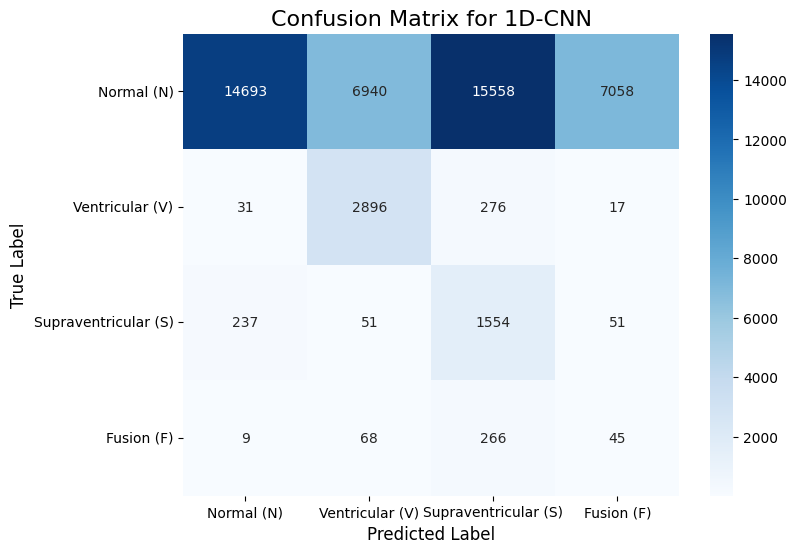

--- Saving model: 1D-CNN ---
INFO:tensorflow:Assets written to: ../models/model_1d-cnn_saved/assets


INFO:tensorflow:Assets written to: ../models/model_1d-cnn_saved/assets


Saved artifact at '../models/model_1d-cnn_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160), dtype=tf.float32, name='keras_tensor_27')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  131662266162768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266165456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266166416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266165648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266166800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266166608: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model 1D-CNN has been saved on: ../models/model_1d-cnn_saved


~~~~~~~~~~~~~~~ REPORT FOR MODEL: RandomForest ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.94      0.94      0.94     44249
     Ventric

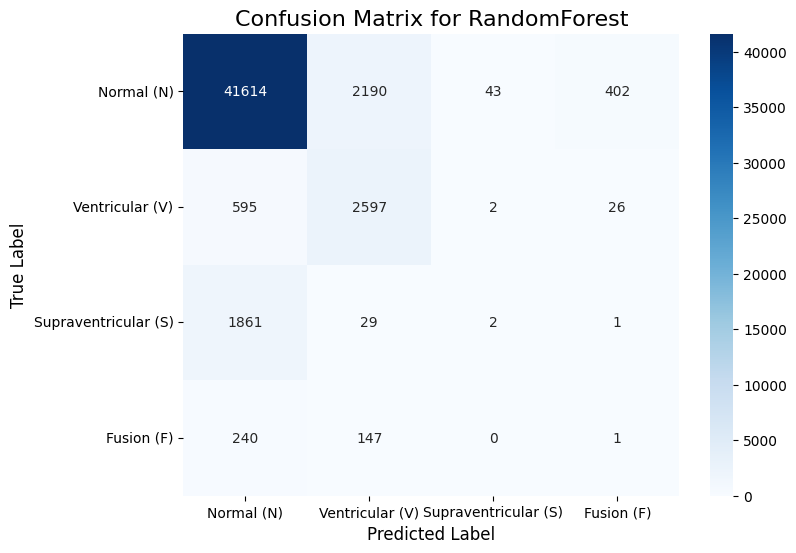

--- Saving model: RandomForest ---
✅ Model RandomForest has been saved on: ../models/model_randomforest.joblib


~~~~~~~~~~~~~~~ REPORT FOR MODEL: MLP ~~~~~~~~~~~~~~~

Classification Report:
                      precision    recall  f1-score   support

          Normal (N)       0.96      0.82      0.88     44249
     Ventricular (V)       0.36      0.86      0.51      3220
Supraventricular (S)       0.22      0.29      0.25      1893
          Fusion (F)       0.00      0.01      0.00       388

            accuracy                           0.79     49750
           macro avg       0.39      0.50      0.41     49750
        weighted avg       0.88      0.79      0.83     49750

Confusion Matrix:


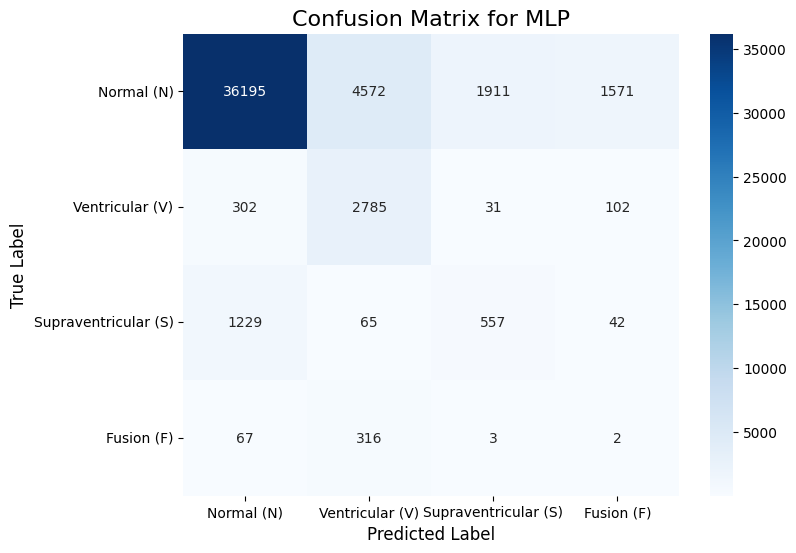

--- Saving model: MLP ---
INFO:tensorflow:Assets written to: ../models/model_mlp_saved/assets


INFO:tensorflow:Assets written to: ../models/model_mlp_saved/assets


Saved artifact at '../models/model_mlp_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160), dtype=tf.float32, name='keras_tensor_27')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  131662266162768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266165456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266166416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266165648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266166800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131662266166608: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model MLP has been saved on: ../models/model_mlp_saved


In [8]:
# Training Multiple Models
input_shape_cnn = (X_train_cnn.shape[1], X_train_cnn.shape[2])
input_dim = X_train_mlp.shape[1]
output_dim = y_train_mlp.shape[1]

# Saving/exporting models
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

# Class Weights
print("--- Calculating Class Weights for Cost-Sensitive Learning ---")
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_fold),
    y=y_train_fold
)
class_weights_dict = dict(enumerate(class_weights))
print("Calculated Weights:", class_weights_dict)

models = {
    "1D-CNN": create_cnn_model_optimized(input_shape_cnn, output_dim),
    "RandomForest": create_rf_model(),
    "MLP": create_mlp_model(input_dim, output_dim)
}

# Dictionary to store the final results
results = {}

# --- TRAINING AND EVALUATING EACH MODEL ---

for name, model in models.items():
    print(f"\n{'='*20} TRAINING MODEL: {name} {'='*20}")

    # 🧠 Training
    if name == "1D-CNN":
        model.fit(
            X_train_cnn, y_train_cnn,
            epochs=10, # Reduced for quick example
            batch_size=32,
            verbose=1, # Set to 0 to keep output clean
            validation_data=(X_val_cnn, y_val_cnn),
            class_weight=class_weights_dict
        )
    elif name == "MLP":
        model.fit(
            X_train_mlp, y_train_mlp,
            epochs=10, # Reduced for quick example
            batch_size=32,
            verbose=1,
            validation_data=(X_val_mlp, y_val_mlp),
            class_weight=class_weights_dict
        )
    else: # 📊 RandomForest
        model.fit(X_train_rf, y_train_rf)

    # ⚡ Prediction on the Test Set
    print(f"Evaluating model {name}...")
    if name in ["MLP", "1D-CNN"]:
        y_pred_raw = model.predict(X_test_mlp if name == "MLP" else X_test_cnn)
        y_pred = np.argmax(y_pred_raw, axis=1)
    else: # RandomForest
        y_pred = model.predict(X_test_rf)

    # Store prediction results and ground truth for final evaluation
    results[name] = {'y_pred': y_pred, 'y_true': y_test_final}

# --- PRINT ALL RESULTS SIMULTANEOUSLY ---
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)']

print(f"\n{'='*25} FINAL EVALUATION RESULTS {'='*25}")

for name, result_data in results.items():
    y_true = result_data['y_true']
    y_pred = result_data['y_pred']

    print(f"\n\n{'~'*15} REPORT FOR MODEL: {name} {'~'*15}")
    
    # --- Classification Report ---
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
    print(report)

    # --- Confusion Matrix Visualization ---
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {name}', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

    # SAVING MODEL AFTER TRAINING
    print(f"--- Saving model: {name} ---")
    if name in ["1D-CNN", "MLP"]:
        # TensorFlow/Keras models
        model_path = os.path.join(output_dir, f"model_{name.lower()}_saved")
        model.export(model_path) # Saving models
        print(f"✅ Model {name} has been saved on: {model_path}")
    else: #RandomForest/other scikit-learn models
        model_path = os.path.join(output_dir, f"model_{name.lower()}.joblib")
        joblib.dump(model, model_path) # Saving models
        print(f"✅ Model {name} has been saved on: {model_path}")

In [ ]:
# Training MLP Model - TA242501010
# Initialize AI model
model = create_mlp_model(input_dim, output_dim)

# Prepare EarlyStopping callback for F1 score validation
early_stopping_1 = EarlyStopping(monitor='val_f1_score', patience=5, restore_best_weights=True)

# Prepare class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Start AI model training
history = model.fit(
    X_train_resampled,
    y_train_resampled_encoded,
    epochs=20,
    batch_size=16,
    validation_data=(X_val_fold, y_val_fold_encoded),
    verbose=1,
    # class_weight=class_weight_dict,
    validation_split=0.2
    # callbacks=[early_stopping_1]
)

# Evaluate on the untouched set
print("Evaluating on the untouched test set...")
X_test_scaled = scaler.transform(X_test)
y_pred_test_raw = model.predict(X_test_scaled)

# Convert predictions back to labels if they are one-hot encoded
if hasattr(y_pred_test_raw, 'shape') and len(y_pred_test_raw.shape) > 1:
      y_pred_test = np.argmax(y_pred_test_raw, axis=1)
else:
      y_pred_test = y_pred_test_raw

class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)', 'Unknown (Q)']

print("\nClassification Report on the Test Set:")
print(classification_report(y_test, y_pred_test, target_names=class_names))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Calculate metrics for each class (one-vs-rest)
print("\nAdditional Metrics Report:")
print("="*55)
for i in range(len(class_names)):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    tp = cm[i,i]
    fp = cm[:,i].sum() - cm[i,i]
    fn = cm[i,:].sum() - cm[i,i]

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    # False Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f"Class: {class_names[i]}")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity         : {specificity:.4f}")
    print(f"  False Positive Rate : {fpr:.4f}")
    print("-"*25)

In [ ]:
# Automatic Hyperparameter Tuning
print("\n--- Starting Automatic Hyperparameter Tuning with KerasTuner ---")

# Calculate class_weight only once
# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weight_dict = dict(enumerate(class_weights))

# Defining tuner objectives
multi_objectives = [
    kt.Objective("val_f1_score", direction="max")
    #kt.Objective("val_specificity", direction="max")
    #kt.Objective("val_precision", direction="max")
    #kt.Objective("val_recall", direction="max")
    #kt.Objective("val_auc_roc", direction="max")
    #kt.Objective("val_auc_pr", direction="max")
]
# Initialize Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective=multi_objectives, # Target: maximize validation F1 score
    max_trials=20,              # Total number of hyperparameter combinations to be tried
    executions_per_trial=1,     # Number of models trained per combination (for stability)
    directory='keras_tuner_dir',
    project_name='ecg_classification_0834' # Can change the name to find the latest parameters with the latest code
)

# Prepare EarlyStopping callback for F1 score validation
early_stopping = EarlyStopping(monitor='val_f1_score', patience=5, restore_best_weights=True)

# Run the search
print("\nStarting the search for the best hyperparameters...")
tuner.search(
    X_train_resampled,              # Training data that has been processed with SMOTE
    y_train_resampled_encoded,
    epochs=100,
    validation_data=(X_val_fold, y_val_fold_encoded), # 1. Use validation_data
    # class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best hyperparameters and the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
--- Search Complete ---
Best hyperparameters found:
- Units 1: {best_hps.get('units_1')}
- Dropout 1: {best_hps.get('dropout_1'):.2f}
- Units 2: {best_hps.get('units_2')}
- Dropout 2: {best_hps.get('dropout_2'):.2f}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# --- Final Evaluation on the Test Set ---
print("\n--- Evaluating the Best Model on the Test Set ---")
X_test_scaled = scaler.transform(X_test) # Use the same scaler from training
y_pred_test_raw = best_model.predict(X_test_scaled)
y_pred_test = np.argmax(y_pred_test_raw, axis=1)
class_names = ['Normal (N)', 'Ventricular (V)', 'Supraventricular (S)', 'Fusion (F)', 'Unknown (Q)']

# --- 1. Classification Report ----
print("\nClassification Report on the Test Set:")
print(classification_report(y_test, y_pred_test, target_names=class_names))

# --- 2. Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# --- 3. Specific Metric Calculation per Class ---
print("\n--- Detailed Performance Metrics per Class ---")
metrics_data = []

for i, class_name in enumerate(class_names):
    # Specificity calculation
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    metrics_data.append({
        "Class": class_name,
        "Precision": precision_score(y_test, y_pred_test, average=None)[i],
        "Sensitivity (Recall)": recall_score(y_test, y_pred_test, average=None)[i],
        "F1-Score": f1_score(y_test, y_pred_test, average=None)[i],
        "Specificity": specificity
    })

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string())


# --- 4. Calculation of AUC-ROC and AUC-PR (One-vs-Rest) ---
y_test_encoded = to_categorical(y_test, num_classes=output_dim)

# Add this line to define y_pred_proba
y_pred_proba = best_model.predict(X_test_scaled)

# AUC-ROC
auc_roc_ovr = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\nAUC-ROC (One-vs-Rest, Weighted): {auc_roc_ovr:.4f}")

# AUC-PR
# Calculate for each class and average
precision_curves = dict()
recall_curves = dict()
auc_pr_scores = []
for i in range(output_dim):
    precision_curves[i], recall_curves[i], _ = precision_recall_curve(y_test_encoded[:, i], y_pred_proba[:, i])
    auc_pr_scores.append(auc(recall_curves[i], precision_curves[i]))

# Weighted average for AUC-PR
support = np.bincount(y_test)
avg_auc_pr = np.average(auc_pr_scores, weights=support)
print(f"AUC-PR (One-vs-Rest, Weighted): {avg_auc_pr:.4f}")

# Plotting PR Curves for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    plt.plot(recall_curves[i], precision_curves[i], lw=2, label=f'{class_name} (AUC-PR = {auc_pr_scores[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## **SAVING MACHINE LEARNING MODELS AFTER TRAINING**

In [ ]:
# Cukup panggil model.save() dan berikan nama folder tujuan.
CNN_folder = '../models/1D-CNN'
model_mlp.save(nama_folder_model)

print(f"\nModel MLP telah disimpan dalam folder: '{nama_folder_model}'")

# Gunakan joblib.dump() untuk menyimpan model ke dalam satu file
nama_file_model = 'model_brf.joblib'
joblib.dump(model_brf, nama_file_model)

print(f"\nModel telah disimpan sebagai file: '{nama_file_model}'")